<a href="https://colab.research.google.com/github/miltiadiss/CEID_NE577-5G-Architectures-Technologies-Applications-and-Key-Performance-Indexes/blob/main/Code/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Libraries**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
import warnings
warnings.filterwarnings("ignore")

# **PREPROCESSING AND DATASET EXPLORATION**

**Fisrt, we load the dataset, remove dublicates and unecessary columns. Also add 'scenario' column.**

In [3]:
data_dir = "/content/drive/MyDrive/Dataset"

# Σενάρια κίνησης (ονομασίες φακέλων)
scenarios = ["train", "pedestrian", "static", "car", "bus"]

# Στήλες που είναι συμβολοσειρές
string_columns = ["State", "NetworkMode", "Operatorname", "Timestamp"]

# Αρχικοποίηση λίστας για την αποθήκευση των DataFrames
trace_dataframes = []

# Διατρέχουμε κάθε φάκελο (σενάριο κίνησης)
for scenario in scenarios:
    scenario_path = os.path.join(data_dir, scenario)

    if os.path.exists(scenario_path):
        for file in os.listdir(scenario_path):
            if file.endswith(".csv"):  # Φιλτράρισμα μόνο των CSV αρχείων
                file_path = os.path.join(scenario_path, file)

                try:
                    # Φόρτωση CSV με αυτόματη αναγνώριση τύπων δεδομένων
                    df = pd.read_csv(file_path, dtype=str)  # Διατηρούμε strings ως έχουν

                    # Καθαρισμός του timestamp χωρίς μετατροπή σε datetime
                    if 'Timestamp' in df.columns:  # Ensure case sensitivity
                        df['Timestamp'] = df['Timestamp'].astype(str).str.strip()
                        df['Timestamp'] = df['Timestamp'].str.replace('_', ' ', regex=False)  # Αντικατάσταση '_' με ' '

                    # Αντικατάσταση "-" στις αριθμητικές στήλες με NaN
                    for col in df.columns:
                        if col not in string_columns:
                            df[col] = df[col].replace("-", np.nan)
                            df[col] = pd.to_numeric(df[col], errors='coerce')

                    # Αφαίρεση διπλότυπων εγγραφών
                    df.drop_duplicates(inplace=True)

                    # Αφαίρεση στηλών που περιέχουν τις συντεταγμένες του mobile device και του cell
                    df.drop(columns=['Longitude', 'Latitude', 'ServingCell_Lon', 'ServingCell_Lat'], inplace=True)

                    # Προσθήκη ετικέτας σεναρίου κίνησης
                    df['scenario'] = scenario

                    # Αποθήκευση του DataFrame στη λίστα
                    trace_dataframes.append(df)

                except Exception as e:
                    print(f"Σφάλμα κατά την επεξεργασία του αρχείου {file_path}: {e}")

# Συνένωση όλων των traces σε ένα ενιαίο DataFrame
if trace_dataframes:
    combined_data = pd.concat(trace_dataframes, ignore_index=True)
    combined_data.to_csv("/content/drive/MyDrive/combined_dataset.csv", index=False, na_rep="NaN")

# Εμφάνιση του τελικού σχήματος των δεδομένων
print(combined_data.shape)

(173692, 17)


**We now sort the dataset instances based on the timestamp is ascending order.**

In [4]:
# Συνένωση όλων των traces σε ένα ενιαίο DataFrame
if trace_dataframes:
    combined_data = pd.concat(trace_dataframes, ignore_index=True)

    # Διόρθωση μορφής ημερομηνίας και μετατροπή σε datetime
    combined_data["Timestamp"] = pd.to_datetime(combined_data["Timestamp"], format="%Y.%m.%d %H.%M.%S", errors="coerce")

    # Ταξινόμηση του DataFrame βάσει χρονικής σειράς
    combined_data = combined_data.sort_values(by="Timestamp").reset_index(drop=True)

In [5]:
combined_data

,Timestamp,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,NRxRSRP,NRxRSRQ,ServingCell_Distance,scenario
0,2017-11-21 15:03:50,0,A,2,LTE,-95,-13.0,4.0,10.0,-80.0,0,0,D,NaN,NaN,551.37,pedestrian
1,2017-11-21 15:03:51,0,A,2,LTE,-95,-13.0,2.0,8.0,-78.0,0,0,I,NaN,NaN,551.37,pedestrian
2,2017-11-21 15:03:52,0,A,2,LTE,-95,-13.0,13.0,9.0,-80.0,0,0,I,NaN,NaN,553.43,pedestrian
3,2017-11-21 15:03:53,1,A,2,LTE,-95,-13.0,13.0,9.0,-80.0,0,0,I,NaN,NaN,563.48,pedestrian
4,2017-11-21 15:03:54,1,A,2,LTE,-97,-13.0,-2.0,9.0,-80.0,0,0,I,NaN,NaN,563.48,pedestrian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173687,2018-02-12 16:28:41,0,B,3,LTE,-104,-11.0,13.0,10.0,-83.0,40586,755,D,NaN,NaN,660.10,static
173688,2018-02-12 16:28:42,0,A,2,LTE,-106,-13.0,3.0,7.0,-90.0,4496,79,D,NaN,NaN,404.60,static
173689,2018-02-12 16:28:42,0,B,3,LTE,-104,-11.0,13.0,10.0,-83.0,49120,909,D,NaN,NaN,660.10,static
173690,2018-02-12 16:28:43,0,B,3,LTE,-100,-12.0,16.0,13.0,-81.0,59364,1194,D,NaN,NaN,660.10,static


**Plot the timeseries of target variable and move on to the decomposition of the timeseries into trend, seasonability and residuals.**

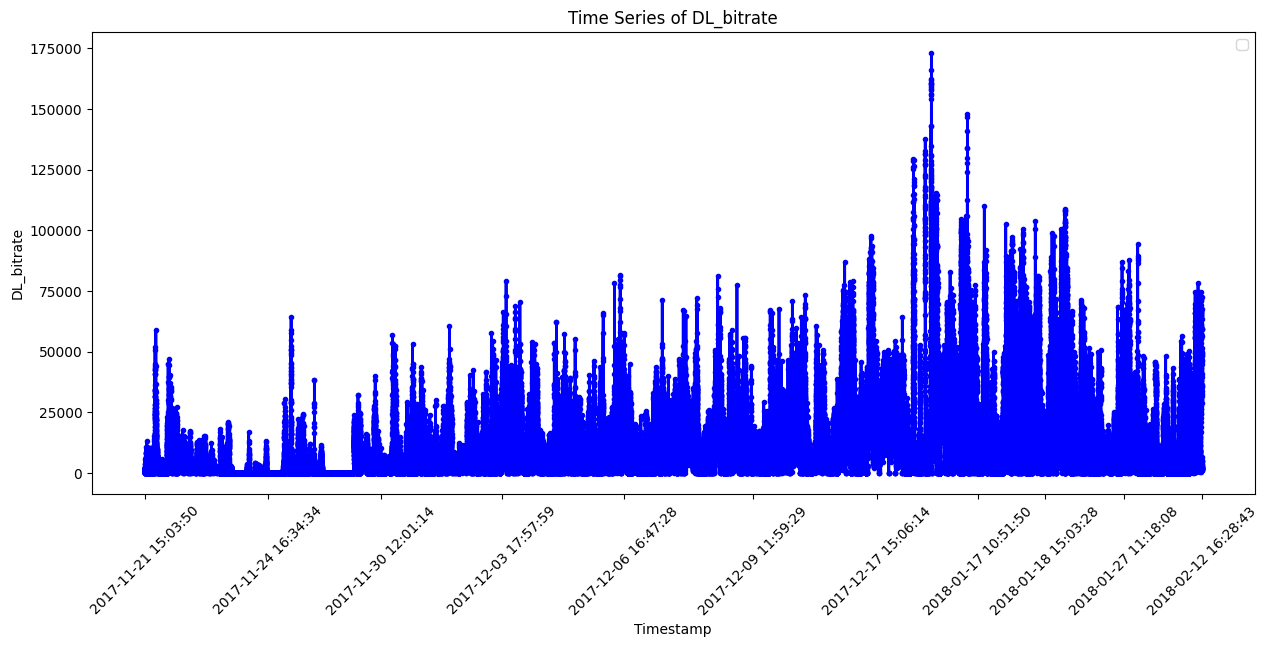

In [6]:
# Convert timestamps to string to use them as categorical values
combined_data['Timestamp'] = combined_data['Timestamp'].astype(str)

# Plot the time series treating Timestamp as categorical data
plt.figure(figsize=(15, 6))
plt.plot(combined_data['Timestamp'], combined_data['DL_bitrate'], marker='o', linestyle='-', markersize=3, color='blue', linewidth=2)
plt.xlabel("Timestamp")
plt.ylabel("DL_bitrate")
plt.title("Time Series of DL_bitrate")

# Reduce the number of displayed ticks on the x-axis for readability
plt.xticks(ticks=combined_data['Timestamp'][::max(1, len(combined_data) // 10)], rotation=45)

plt.legend()
plt.show()

<Figure size 1000x800 with 0 Axes>

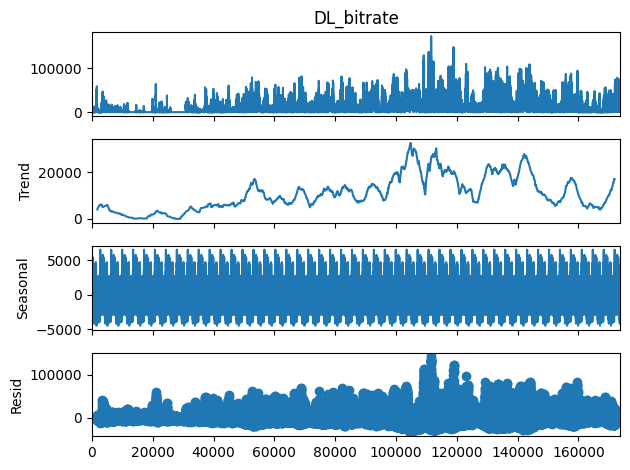

In [7]:
# Seasonal Decomposition
decomposition = seasonal_decompose(combined_data['DL_bitrate'], model='additive', period=3600)  # Use period=3600 for hourly seasonality

# Plot decomposition
plt.figure(figsize=(10, 8))
decomposition.plot()
plt.show()

**Check how target is related with the input features.**

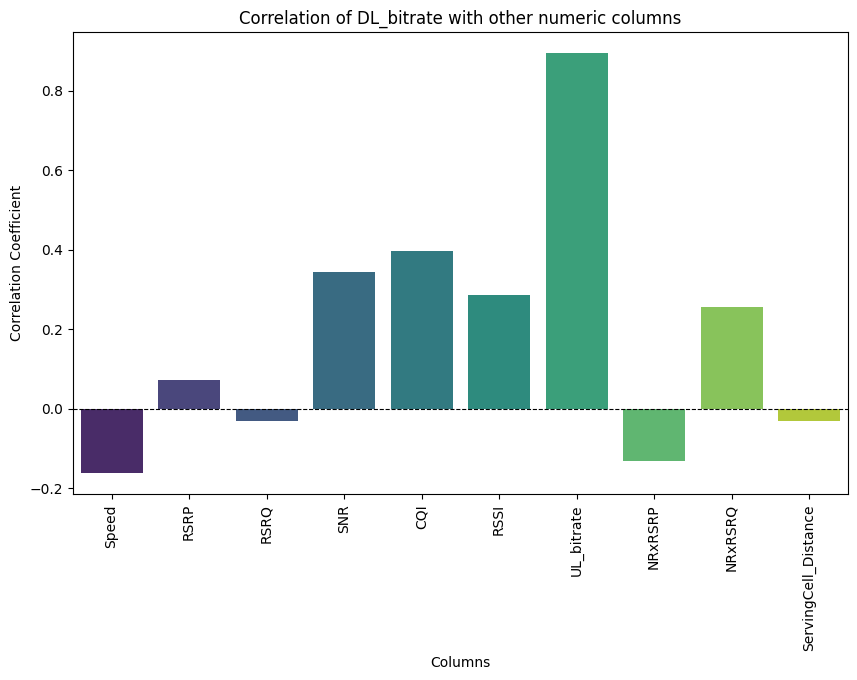

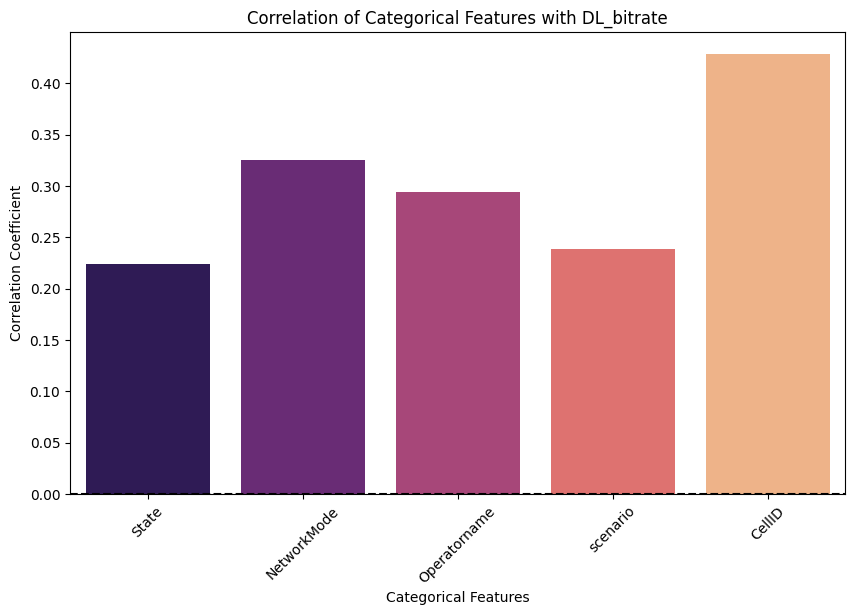

In [8]:
# Αφαίρεση μη αριθμητικών στηλών
non_numeric_columns = ['Timestamp', 'State', 'NetworkMode', 'Operatorname', 'CellID', 'scenario']
numeric_columns = [col for col in combined_data.columns if col not in non_numeric_columns]

# Υπολογισμός συντελεστών συσχέτισης
correlations = combined_data[numeric_columns].corr(method='kendall')

# Εστίαση στη συσχέτιση με τη στήλη DL_bitrate
dl_bitrate_corr = correlations['DL_bitrate'].drop('DL_bitrate')  # Αφαιρούμε τη συσχέτιση της στήλης με τον εαυτό της

# Οπτικοποίηση μέσω barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=dl_bitrate_corr.index, y=dl_bitrate_corr.values, palette='viridis')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title("Correlation of DL_bitrate with other numeric columns")
plt.xticks(rotation=90)
plt.ylabel("Correlation Coefficient")
plt.xlabel("Columns")
plt.show()

# Define categorical columns
categorical_columns = ['State', 'NetworkMode', 'Operatorname', 'scenario', 'CellID']

# Dictionary to store correlations
category_correlations = {}

# Compute correlation for each categorical variable
for cat_col in categorical_columns:
    # Convert categories into their mean DL_bitrate (Target Encoding)
    encoded_values = combined_data.groupby(cat_col)['DL_bitrate'].transform('mean')

    # Compute Pearson correlation between encoded values and target
    correlation = np.corrcoef(encoded_values, combined_data['DL_bitrate'])[0, 1]

    category_correlations[cat_col] = correlation

# Convert dictionary to DataFrame for visualization
category_corr_df = pd.DataFrame.from_dict(category_correlations, orient='index', columns=['Correlation'])

# Plot the categorical correlations as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=category_corr_df.index, y=category_corr_df['Correlation'], palette='magma')
plt.axhline(0, color='black', linestyle='--')
plt.title("Correlation of Categorical Features with DL_bitrate")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Categorical Features")
plt.xticks(rotation=45)
plt.show()

###**Numerical features**

**Replace NULL values with mean value of the numeric feature**

In [9]:
# Φόρτωση δεδομένων
df = pd.read_csv("/content/drive/MyDrive/combined_dataset.csv")

# Διόρθωση μορφής ημερομηνίας και μετατροπή σε datetime
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format="%Y.%m.%d %H.%M.%S", errors="coerce")

# Ταξινόμηση του DataFrame βάσει χρονικής σειράς
df = df.sort_values(by="Timestamp").reset_index(drop=True)

# Αντικατάσταση των NaN τιμών στις αριθμητικές στήλες με τον μέσο όρο τους
for column in numeric_columns:
    df[column] = df[column].interpolate(method='linear', limit_direction='both')


In [10]:
df

,Timestamp,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,NRxRSRP,NRxRSRQ,ServingCell_Distance,scenario
0,2017-11-21 15:03:50,0,A,2,LTE,-95,-13.0,4.0,10.0,-80.0,0,0,D,-106.0,-19.0,551.37,pedestrian
1,2017-11-21 15:03:51,0,A,2,LTE,-95,-13.0,2.0,8.0,-78.0,0,0,I,-106.0,-19.0,551.37,pedestrian
2,2017-11-21 15:03:52,0,A,2,LTE,-95,-13.0,13.0,9.0,-80.0,0,0,I,-106.0,-19.0,553.43,pedestrian
3,2017-11-21 15:03:53,1,A,2,LTE,-95,-13.0,13.0,9.0,-80.0,0,0,I,-106.0,-19.0,563.48,pedestrian
4,2017-11-21 15:03:54,1,A,2,LTE,-97,-13.0,-2.0,9.0,-80.0,0,0,I,-106.0,-19.0,563.48,pedestrian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173687,2018-02-12 16:28:41,0,B,3,LTE,-104,-11.0,13.0,10.0,-83.0,40586,755,D,-90.0,-10.0,660.10,static
173688,2018-02-12 16:28:42,0,A,2,LTE,-106,-13.0,3.0,7.0,-90.0,4496,79,D,-90.0,-10.0,404.60,static
173689,2018-02-12 16:28:42,0,B,3,LTE,-104,-11.0,13.0,10.0,-83.0,49120,909,D,-90.0,-10.0,660.10,static
173690,2018-02-12 16:28:43,0,B,3,LTE,-100,-12.0,16.0,13.0,-81.0,59364,1194,D,-90.0,-10.0,660.10,static


**Use Q-Q plots to check if numeric features follow Normal Distribution**

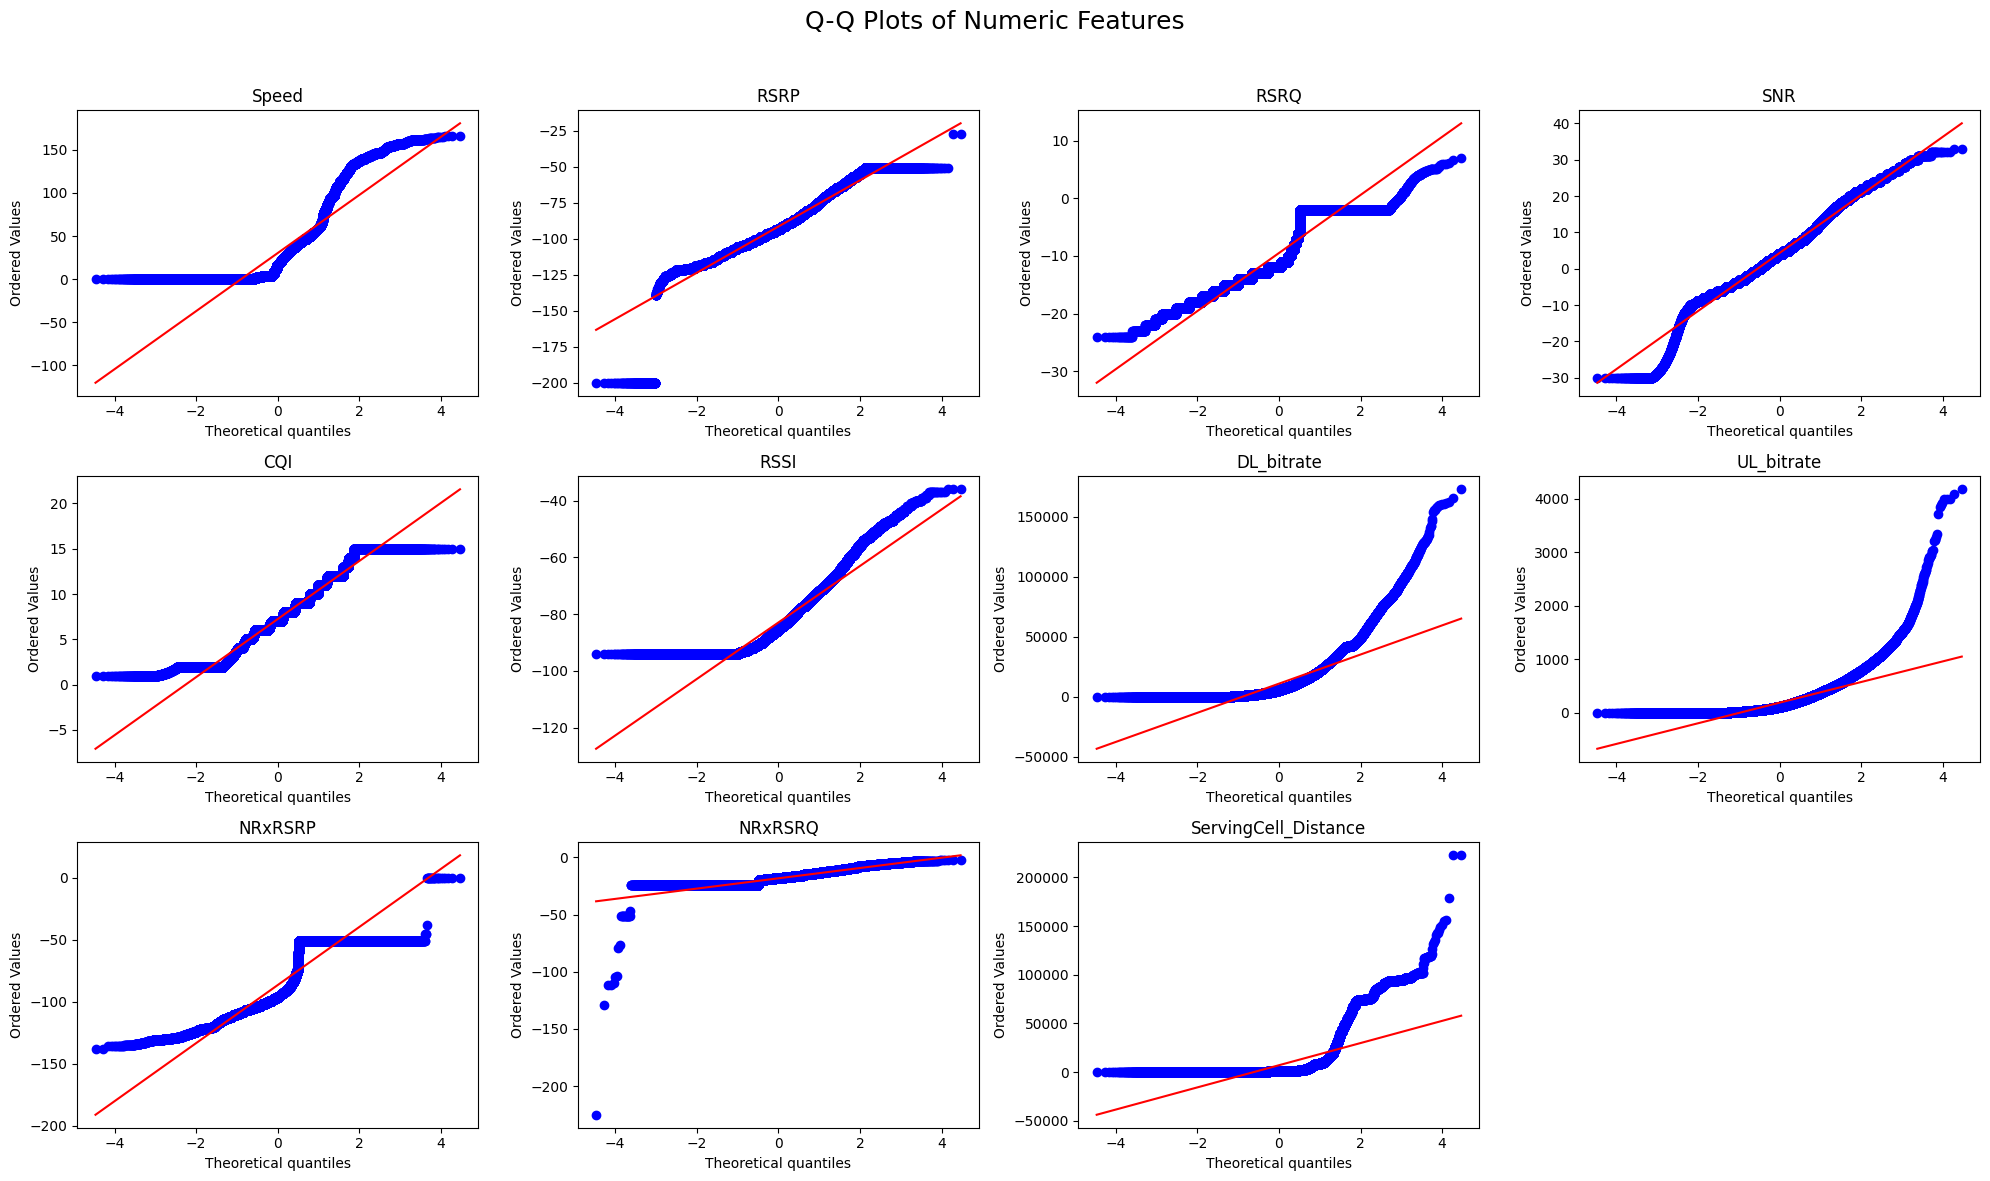

In [11]:
# Ορισμός των διαστάσεων του grid
cols = 4  # Κάθε σειρά έχει 4 plots
rows = math.ceil(len(numeric_columns) / cols)  # Υπολογισμός σειρών δυναμικά

# Δημιουργία figure και subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
fig.suptitle("Q-Q Plots of Numeric Features", fontsize=18)

# Flatten για εύκολη διαχείριση
axes = axes.flatten()

# Σχεδίαση Q-Q plots για κάθε χαρακτηριστικό
for i, column in enumerate(numeric_columns):
    stats.probplot(df[column].dropna(), dist="norm", plot=axes[i])
    axes[i].set_title(f'{column}')

# Αφαίρεση κενών subplots αν υπάρχουν
for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

# Προσαρμογή layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Since most features don't follow Normal Distribution, we detect the outliers using the IQR Method and apply capping to correct them.**

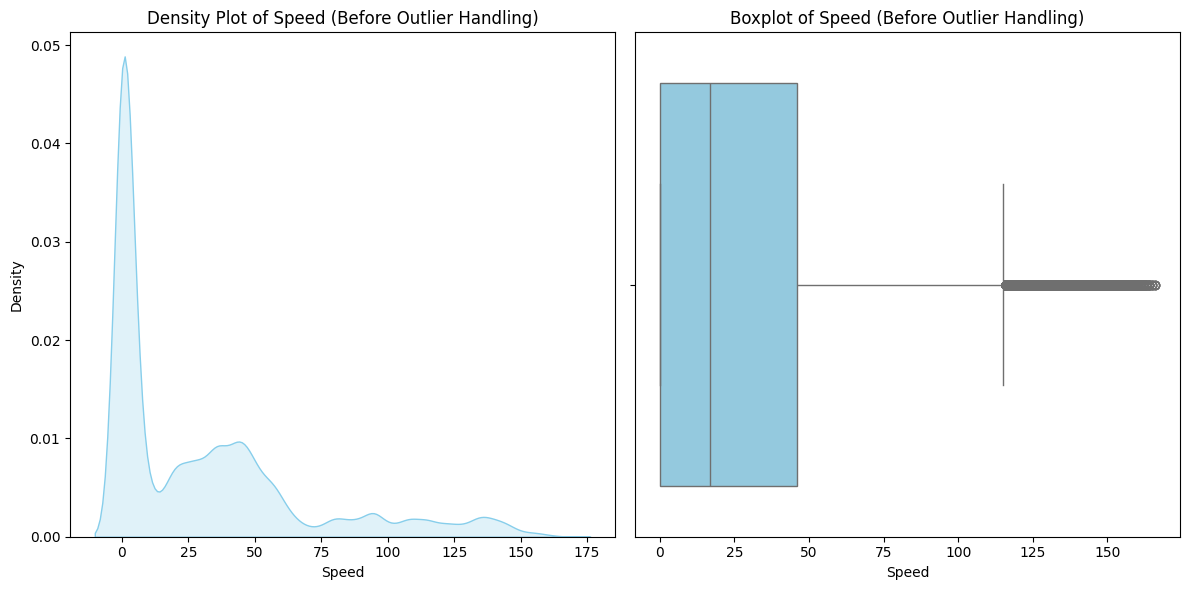

For column Speed:
Q1 = 0.0, Q3 = 46.0, IQR = 46.0
Lower Bound = -69.0, Upper Bound = 115.0
Number of Outliers: 9520



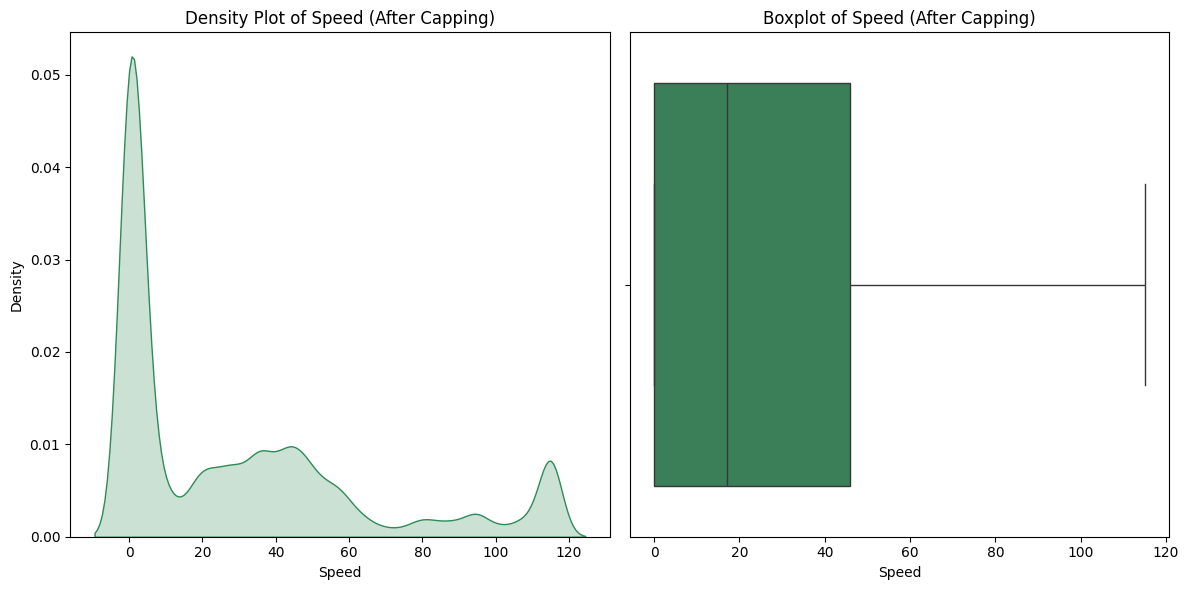

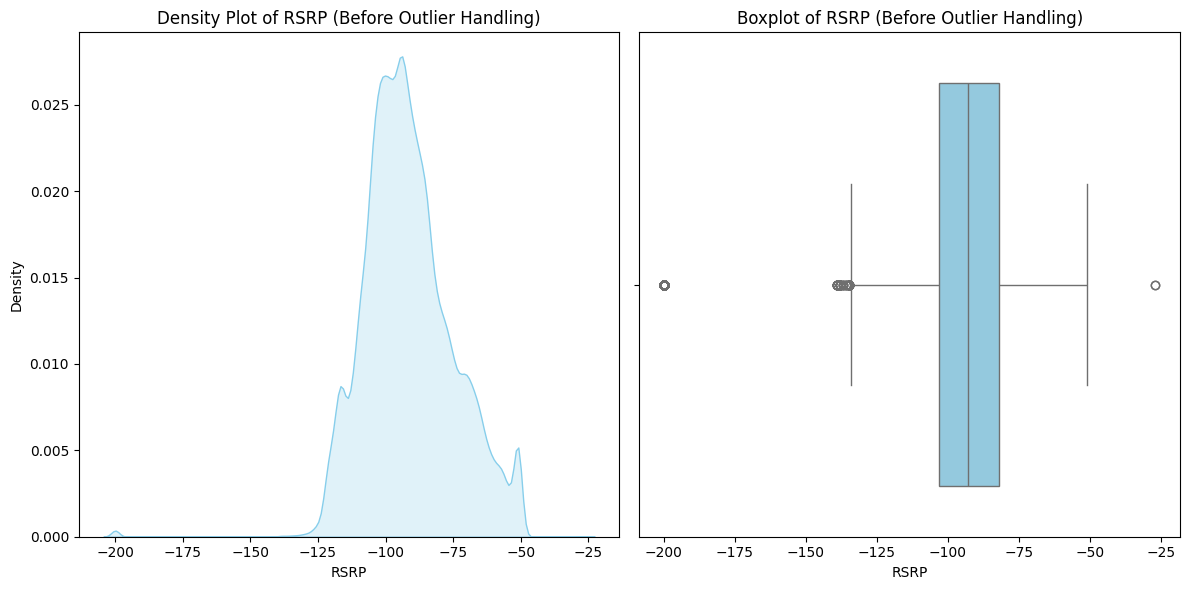

For column RSRP:
Q1 = -103.0, Q3 = -82.0, IQR = 21.0
Lower Bound = -134.5, Upper Bound = -50.5
Number of Outliers: 288



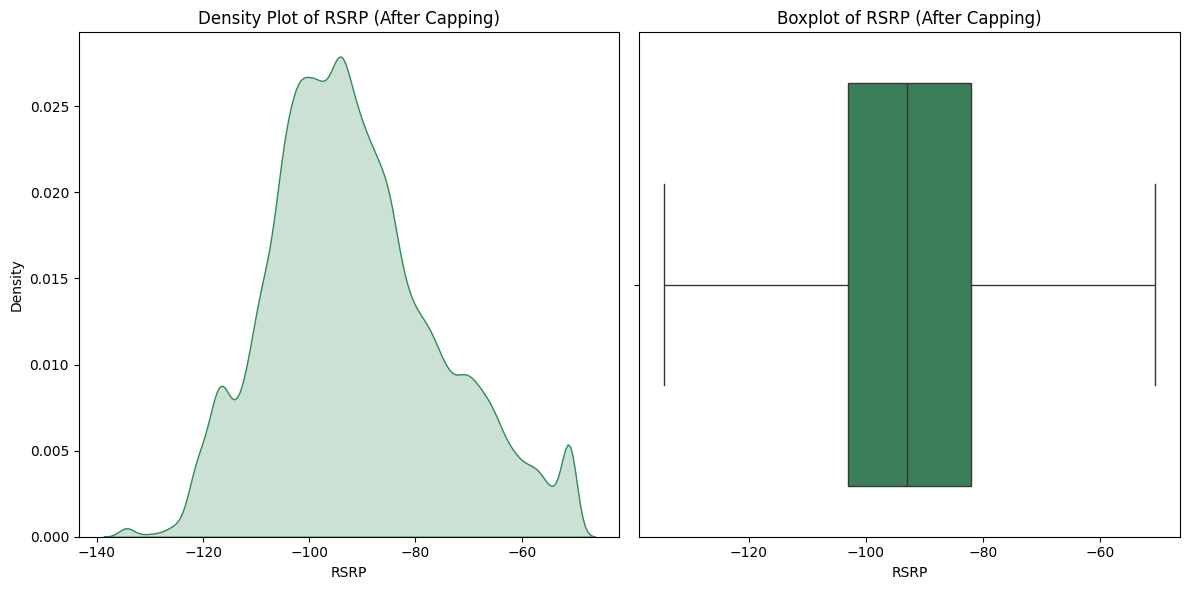

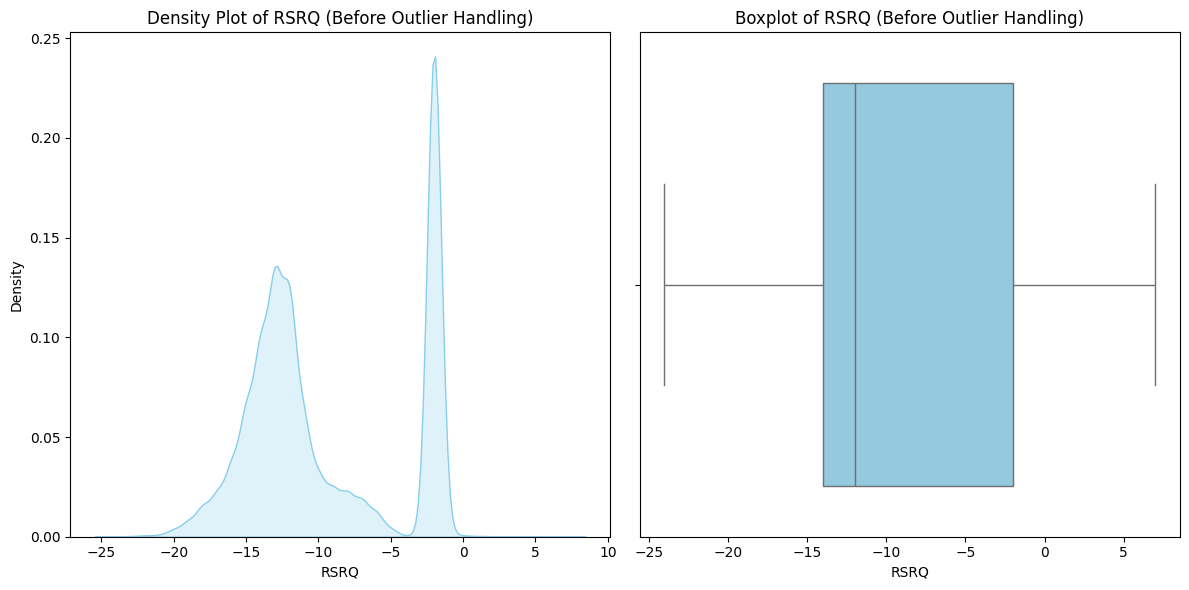

For column RSRQ:
Q1 = -14.0, Q3 = -2.0, IQR = 12.0
Lower Bound = -32.0, Upper Bound = 16.0
Number of Outliers: 0



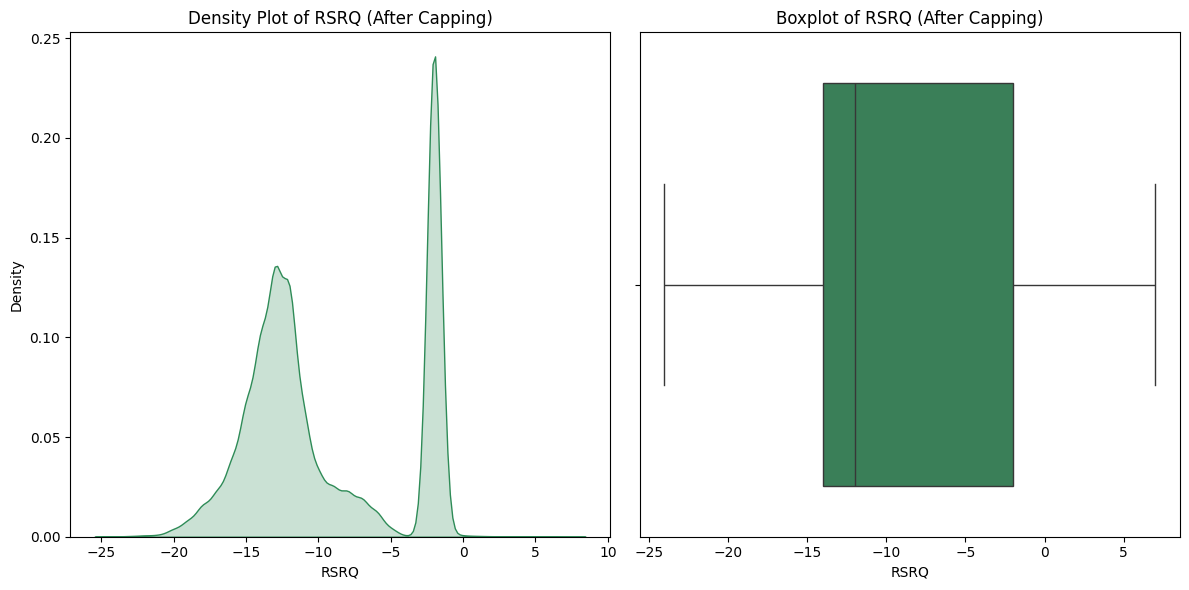

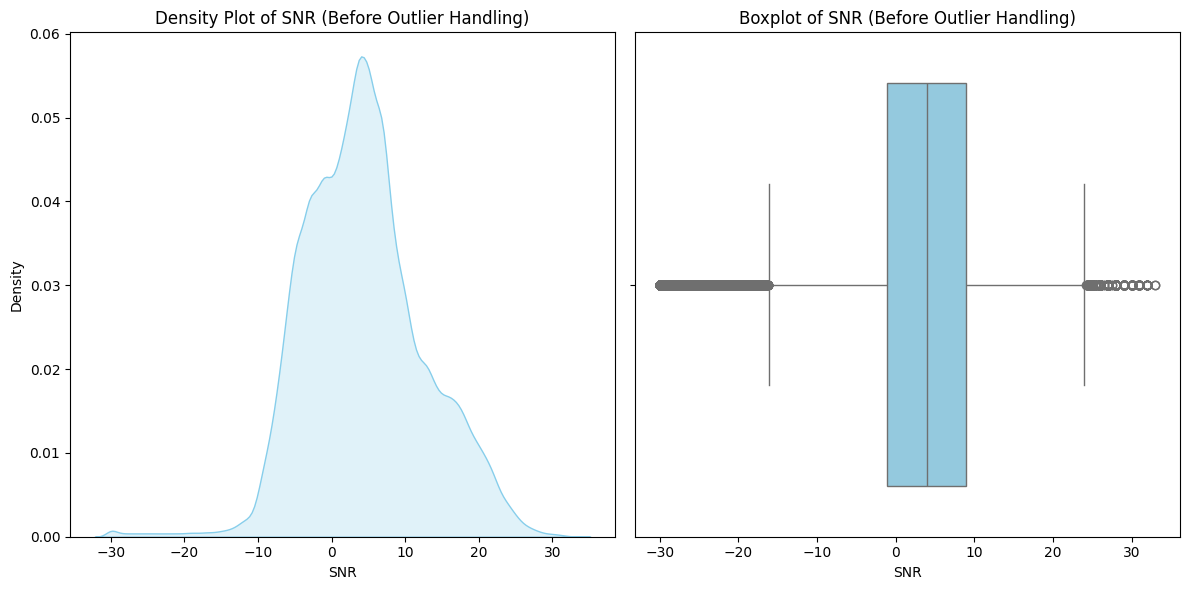

For column SNR:
Q1 = -1.0667037861915365, Q3 = 9.0, IQR = 10.066703786191537
Lower Bound = -16.16675946547884, Upper Bound = 24.100055679287305
Number of Outliers: 2386



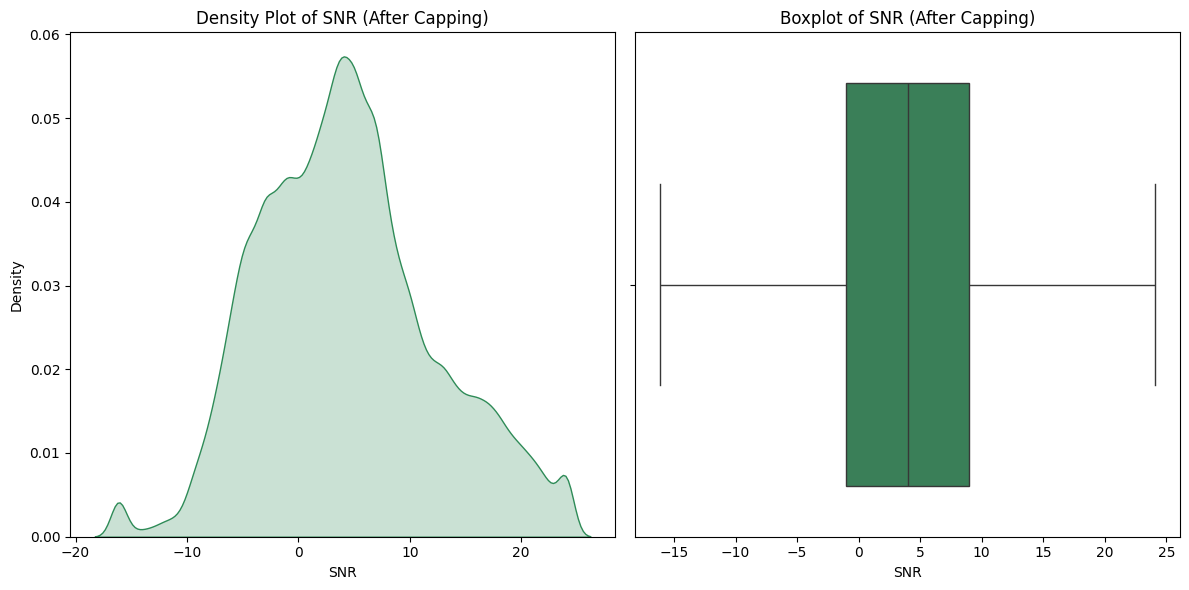

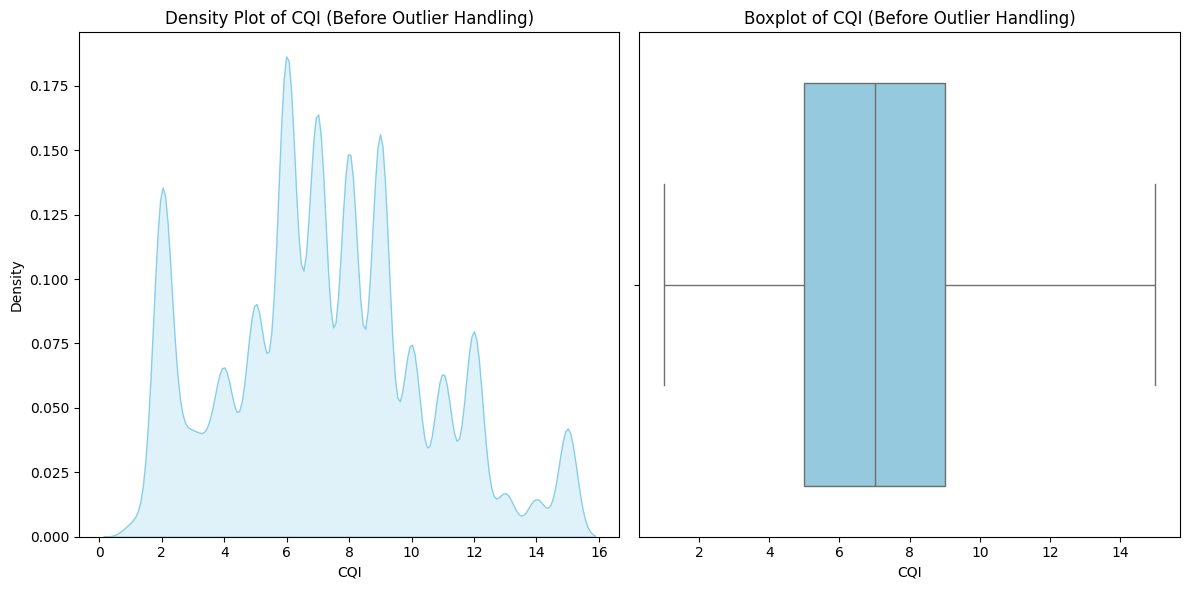

For column CQI:
Q1 = 5.0, Q3 = 9.0, IQR = 4.0
Lower Bound = -1.0, Upper Bound = 15.0
Number of Outliers: 0



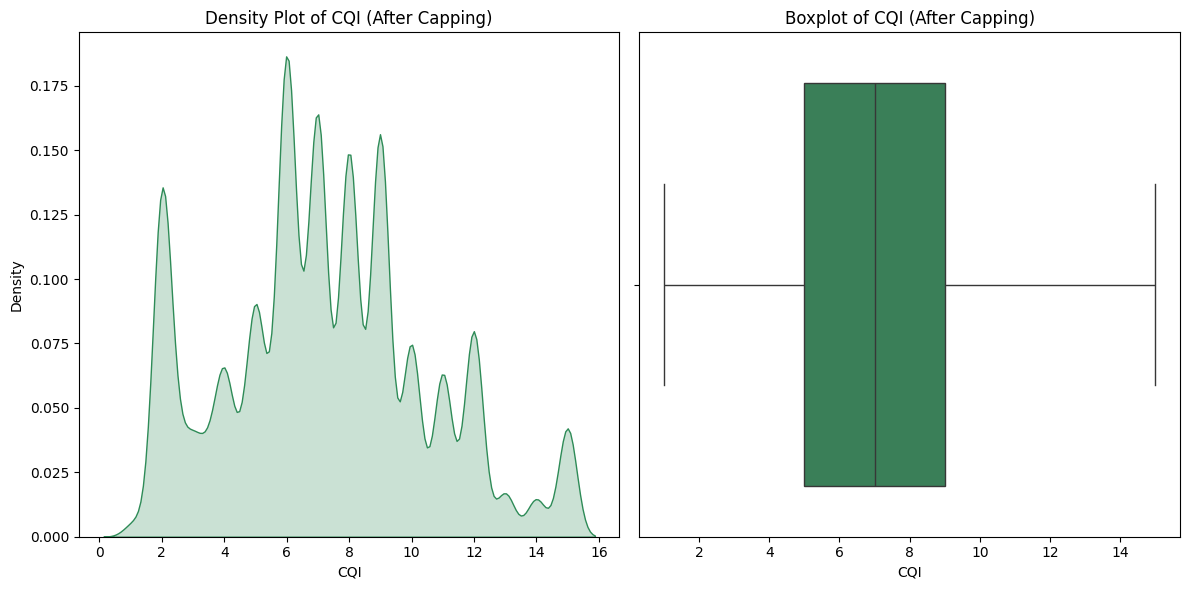

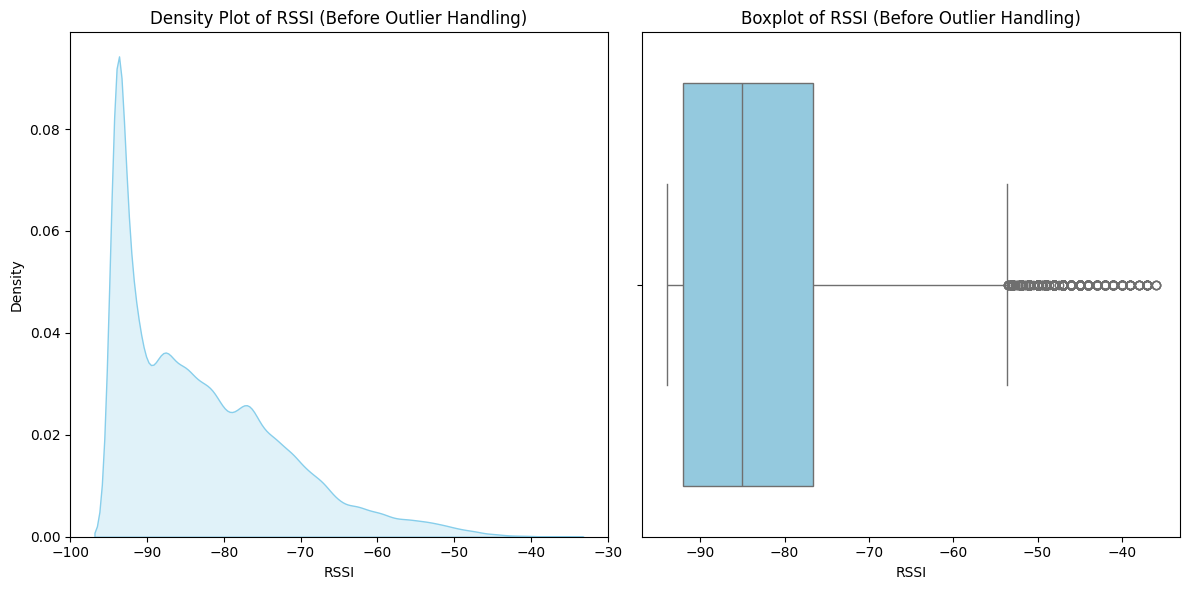

For column RSSI:
Q1 = -92.04176177998096, Q3 = -76.67059333223304, IQR = 15.37116844774792
Lower Bound = -115.09851445160284, Upper Bound = -53.61384066061116
Number of Outliers: 2702



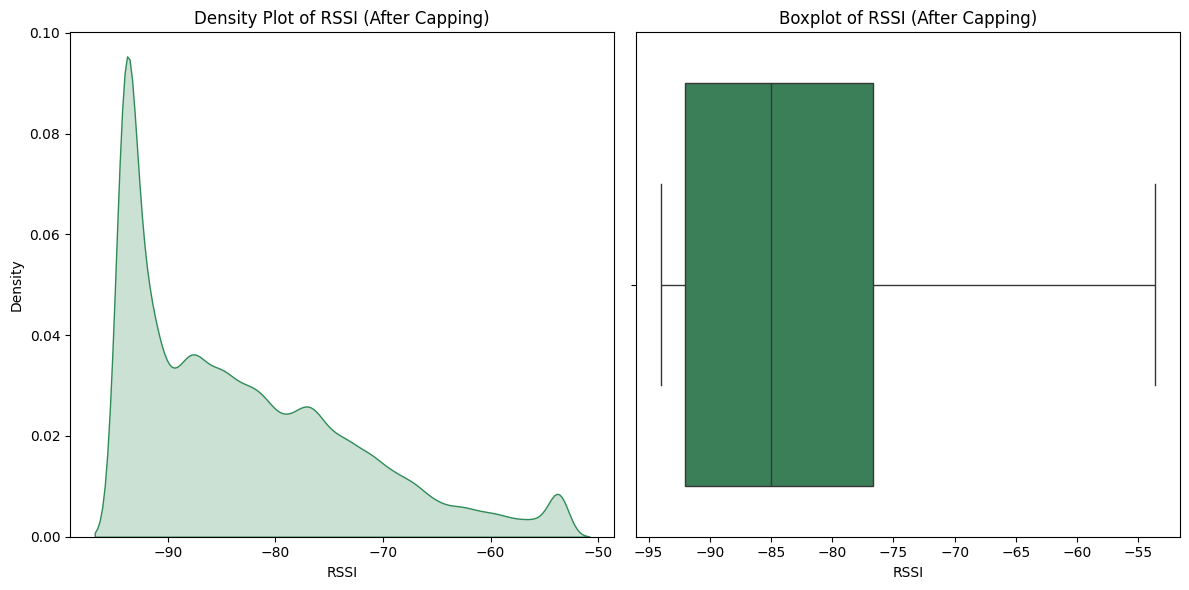

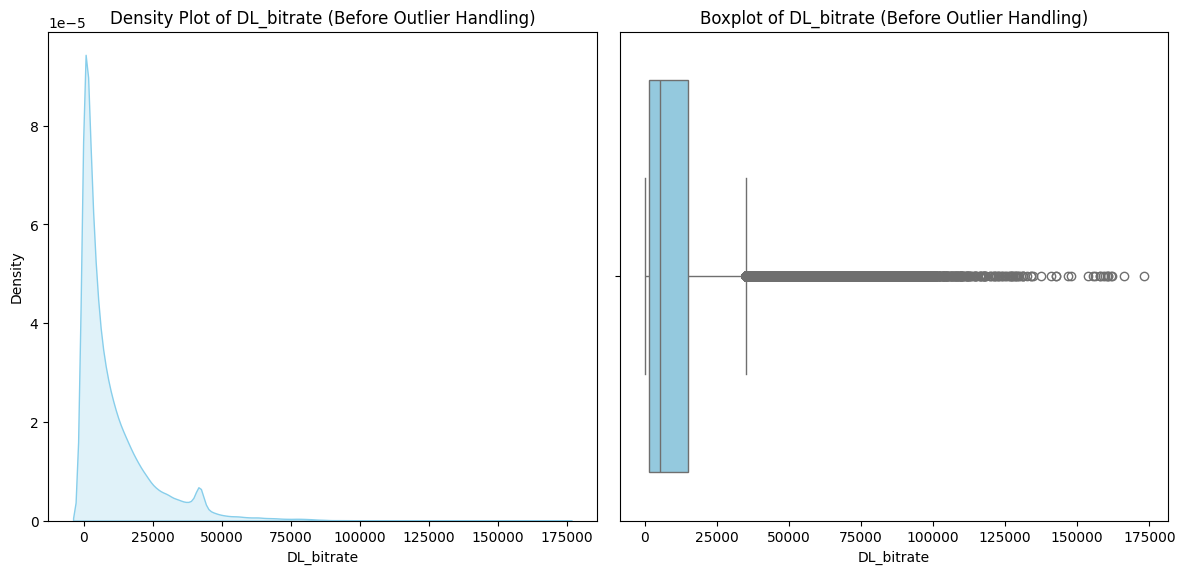

For column DL_bitrate:
Q1 = 1420.0, Q3 = 14841.0, IQR = 13421.0
Lower Bound = -18711.5, Upper Bound = 34972.5
Number of Outliers: 13177



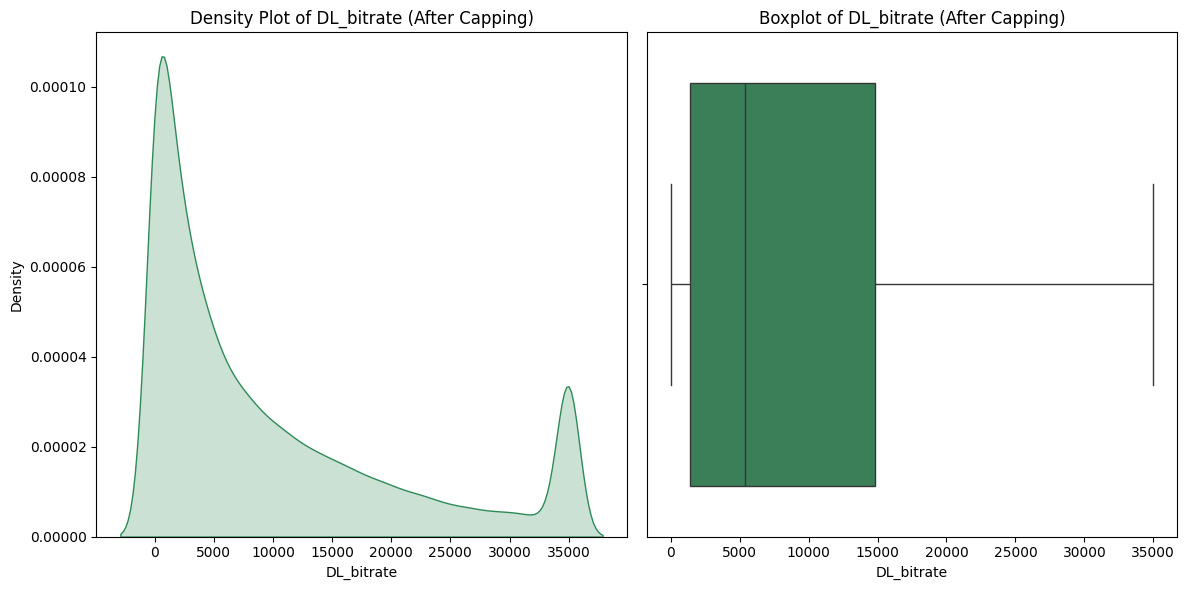

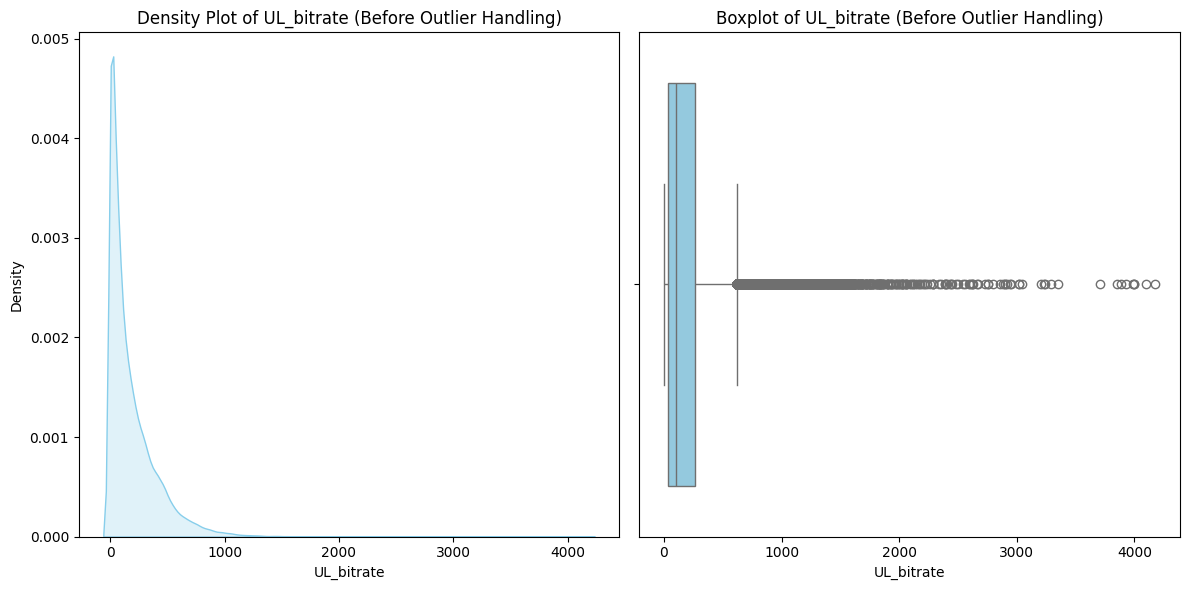

For column UL_bitrate:
Q1 = 32.0, Q3 = 267.0, IQR = 235.0
Lower Bound = -320.5, Upper Bound = 619.5
Number of Outliers: 8533



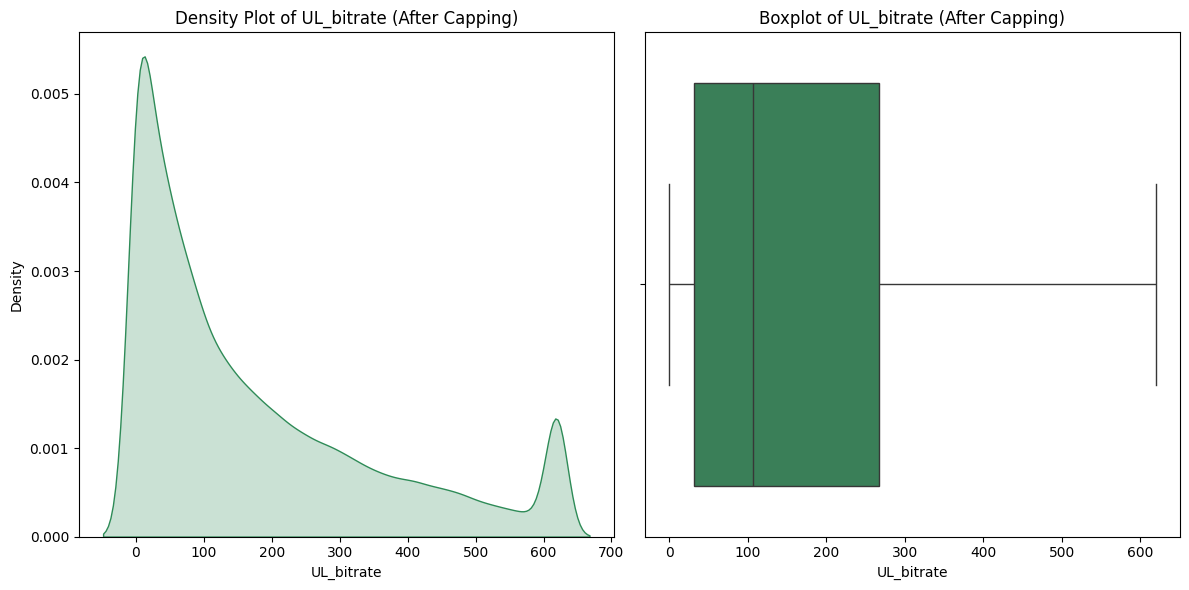

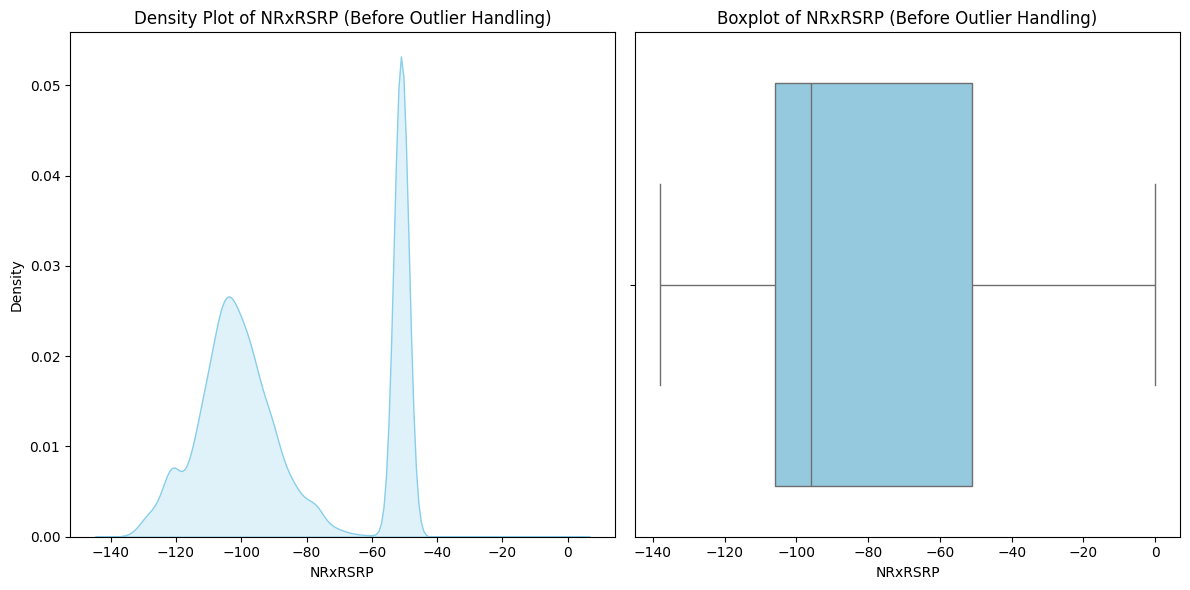

For column NRxRSRP:
Q1 = -106.0, Q3 = -51.0, IQR = 55.0
Lower Bound = -188.5, Upper Bound = 31.5
Number of Outliers: 0



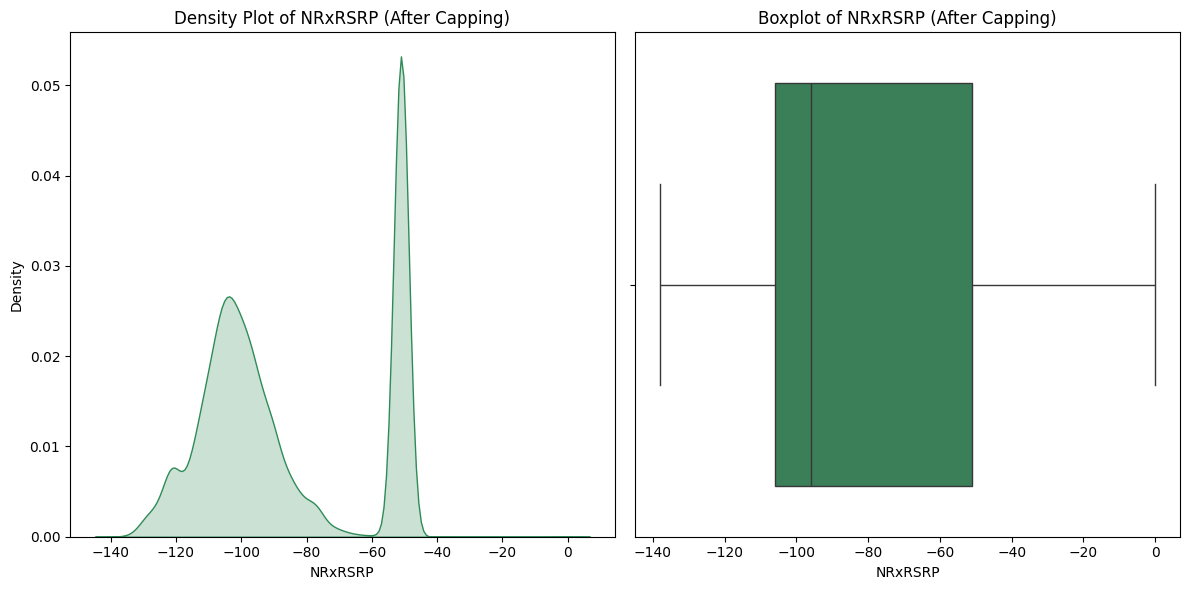

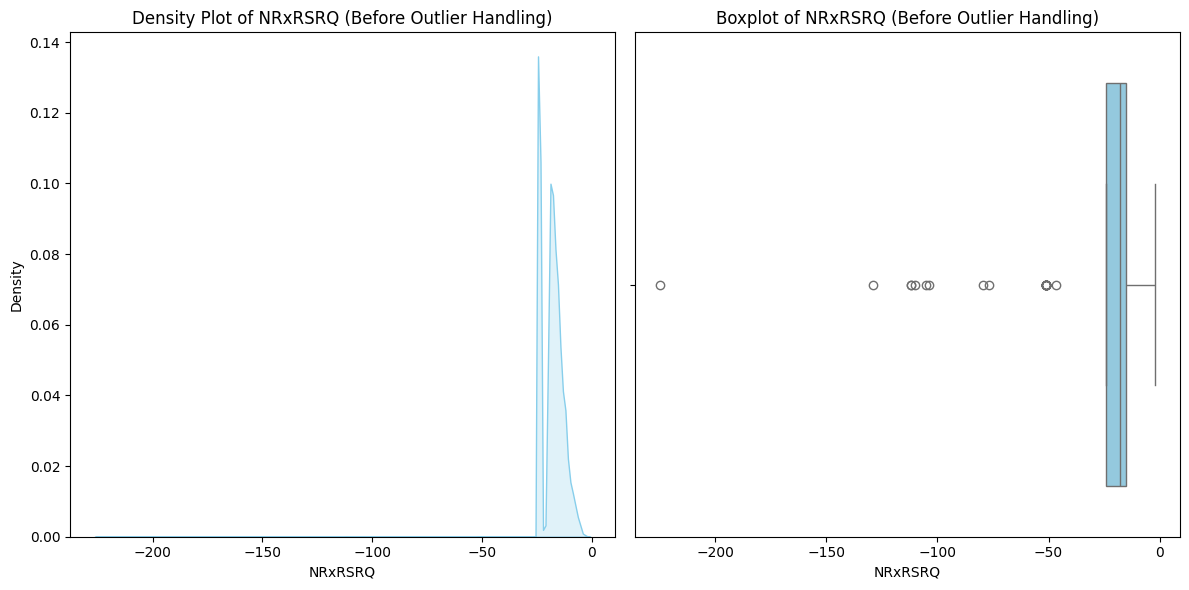

For column NRxRSRQ:
Q1 = -24.0, Q3 = -15.0, IQR = 9.0
Lower Bound = -37.5, Upper Bound = -1.5
Number of Outliers: 25



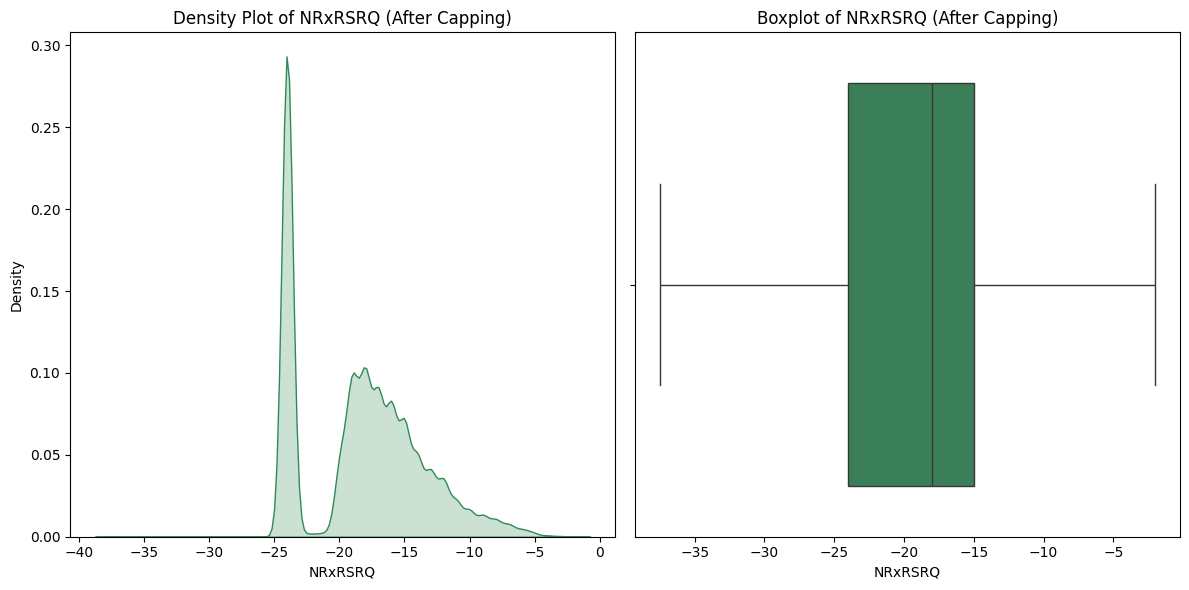

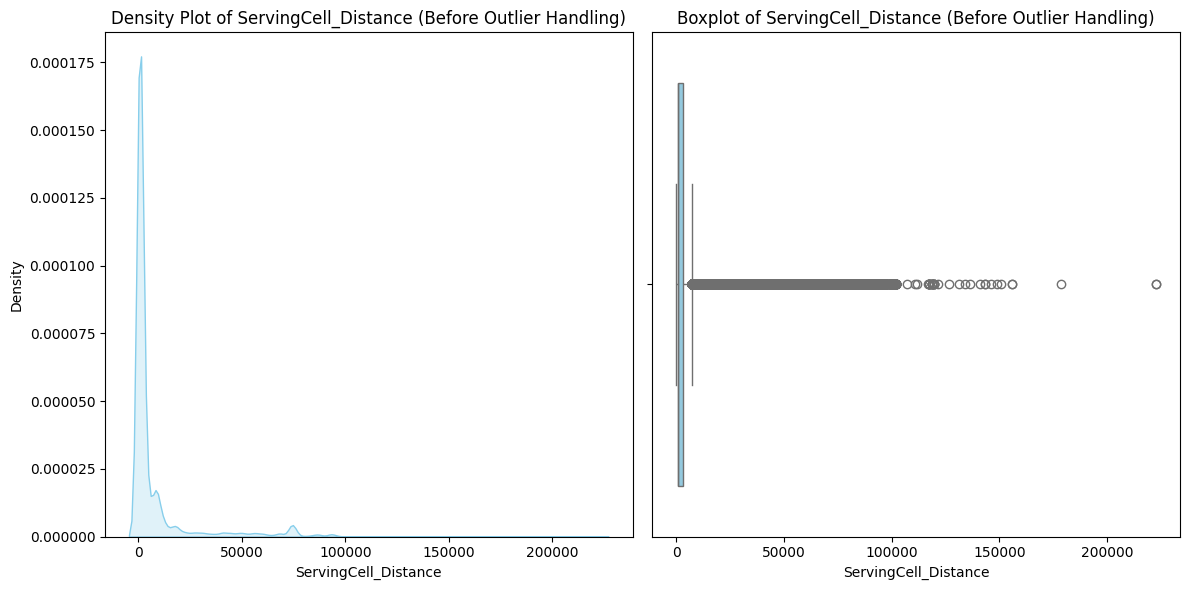

For column ServingCell_Distance:
Q1 = 538.08, Q3 = 3162.9, IQR = 2624.82
Lower Bound = -3399.1500000000005, Upper Bound = 7100.130000000001
Number of Outliers: 34561



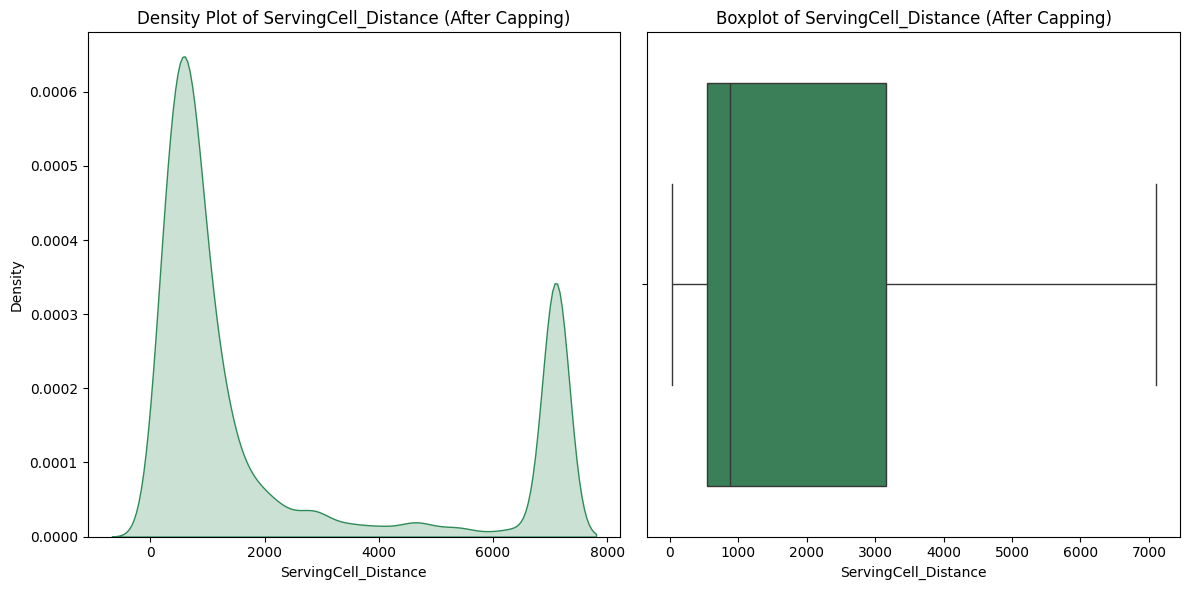

In [12]:
# Εξερεύνηση δεδομένων ανά χαρακτηριστικό
for column in numeric_columns:
    plt.figure(figsize=(12, 6))

    # Density Plot πριν τον χειρισμό των outliers
    plt.subplot(1, 2, 1)
    sns.kdeplot(df[column], fill=True, color="skyblue")
    plt.title(f'Density Plot of {column} (Before Outlier Handling)')
    plt.xlabel(column)

    # Boxplot πριν τον χειρισμό των outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column], color="skyblue")
    plt.title(f'Boxplot of {column} (Before Outlier Handling)')
    plt.xlabel(column)

    plt.tight_layout()
    plt.show()

    # Εντοπισμός outliers βάσει IQR
    Q1 = np.percentile(df[column].dropna(), 25)
    Q3 = np.percentile(df[column].dropna(), 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR  # Χρησιμοποιούμε 1.5 * IQR (ή 3 * IQR αν θέλεις πιο αυστηρό φιλτράρισμα)
    upper_bound = Q3 + 1.5 * IQR

    print(f"For column {column}:")
    print(f"Q1 = {Q1}, Q3 = {Q3}, IQR = {IQR}")
    print(f"Lower Bound = {lower_bound}, Upper Bound = {upper_bound}")
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Number of Outliers: {len(outliers)}")
    print()

    # **Capping των outliers αντί να τα αφαιρούμε**
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

    # Density Plot και Boxplot μετά το capping
    plt.figure(figsize=(12, 6))

    # Density Plot μετά τον χειρισμό των outliers
    plt.subplot(1, 2, 1)
    sns.kdeplot(df[column], fill=True, color="seagreen")
    plt.title(f'Density Plot of {column} (After Capping)')
    plt.xlabel(column)

    # Boxplot μετά το capping
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column], color="seagreen")
    plt.title(f'Boxplot of {column} (After Capping)')
    plt.xlabel(column)

    plt.tight_layout()
    plt.show()

In [ ]:
"""for column in numeric_columns:
    mean_value = df[column].mean()
    std_value = df[column].std()
    df[column] = (df[column] - mean_value) / std_value"""

In [13]:
df

,Timestamp,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,State,NRxRSRP,NRxRSRQ,ServingCell_Distance,scenario
0,2017-11-21 15:03:50,0.0,A,2,LTE,-95.0,-13.0,4.0,10.0,-80.0,0.0,0.0,D,-106.0,-19.0,551.37,pedestrian
1,2017-11-21 15:03:51,0.0,A,2,LTE,-95.0,-13.0,2.0,8.0,-78.0,0.0,0.0,I,-106.0,-19.0,551.37,pedestrian
2,2017-11-21 15:03:52,0.0,A,2,LTE,-95.0,-13.0,13.0,9.0,-80.0,0.0,0.0,I,-106.0,-19.0,553.43,pedestrian
3,2017-11-21 15:03:53,1.0,A,2,LTE,-95.0,-13.0,13.0,9.0,-80.0,0.0,0.0,I,-106.0,-19.0,563.48,pedestrian
4,2017-11-21 15:03:54,1.0,A,2,LTE,-97.0,-13.0,-2.0,9.0,-80.0,0.0,0.0,I,-106.0,-19.0,563.48,pedestrian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173687,2018-02-12 16:28:41,0.0,B,3,LTE,-104.0,-11.0,13.0,10.0,-83.0,34972.5,619.5,D,-90.0,-10.0,660.10,static
173688,2018-02-12 16:28:42,0.0,A,2,LTE,-106.0,-13.0,3.0,7.0,-90.0,4496.0,79.0,D,-90.0,-10.0,404.60,static
173689,2018-02-12 16:28:42,0.0,B,3,LTE,-104.0,-11.0,13.0,10.0,-83.0,34972.5,619.5,D,-90.0,-10.0,660.10,static
173690,2018-02-12 16:28:43,0.0,B,3,LTE,-100.0,-12.0,16.0,13.0,-81.0,34972.5,619.5,D,-90.0,-10.0,660.10,static


**Finally, we compute the correlation matrix to see how the numerical features are related.**

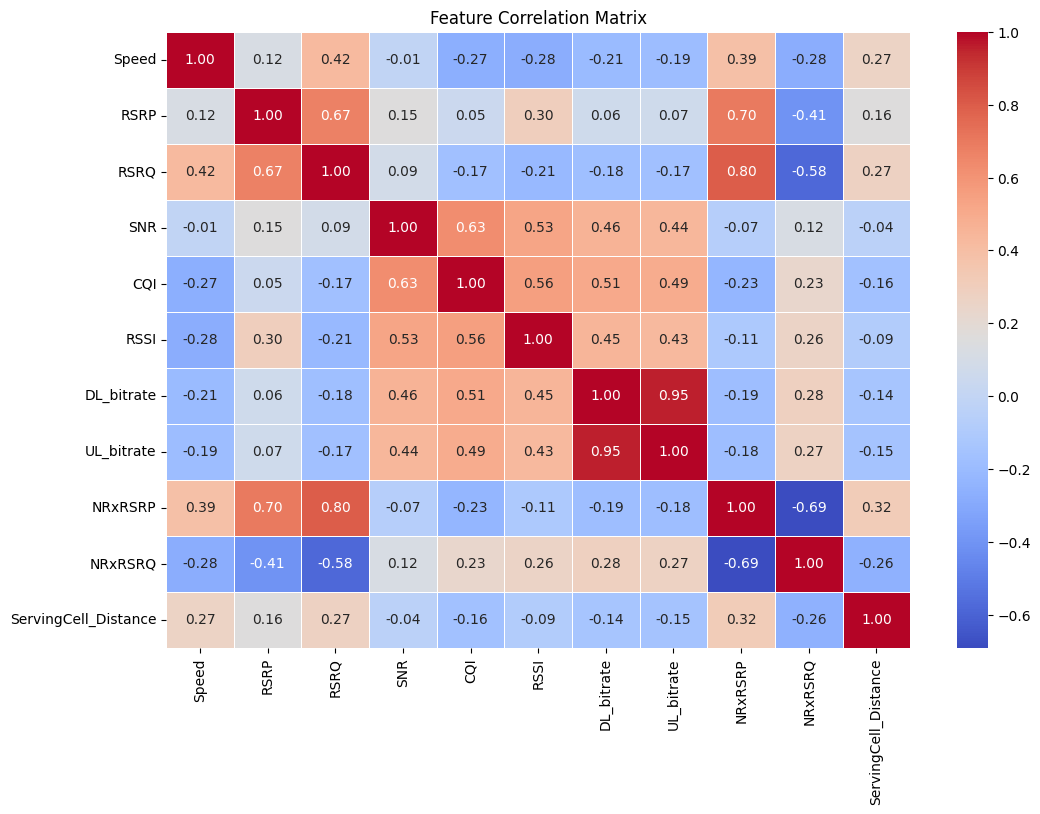

In [14]:
# Compute the correlation matrix
correlation_matrix = df[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

###**Categorical features**

**We combine all the categorical features in one numerical feature called "Categorical_Impact" using the principal component with the biggest variance from PCA Analysis.**

In [15]:
# Κατηγορικά χαρακτηριστικά προς κωδικοποίηση
categorical_features = ["State", "NetworkMode", "Operatorname", "CellID", "scenario"]

# One-Hot Encoding των κατηγορικών χαρακτηριστικών
encoder = OneHotEncoder(drop='first')
encoded_cats = encoder.fit_transform(df[categorical_features])

# PCA για μείωση διαστάσεων
pca = PCA(n_components=1)  # Κρατάμε μόνο το κύριο component με το μεγαλυτερο variance
categorical_pca_feature = pca.fit_transform(encoded_cats)

# Προσθήκη του νέου feature στο dataframe
df["Categorical_Impact"] = categorical_pca_feature

# Αφαίρεση των αρχικών κατηγορικών χαρακτηριστικών
df.drop(columns=categorical_features, inplace=True)

In [16]:
df

,Timestamp,Speed,RSRP,RSRQ,SNR,CQI,RSSI,DL_bitrate,UL_bitrate,NRxRSRP,NRxRSRQ,ServingCell_Distance,Categorical_Impact
0,2017-11-21 15:03:50,0.0,-95.0,-13.0,4.0,10.0,-80.0,0.0,0.0,-106.0,-19.0,551.37,0.664633
1,2017-11-21 15:03:51,0.0,-95.0,-13.0,2.0,8.0,-78.0,0.0,0.0,-106.0,-19.0,551.37,0.536313
2,2017-11-21 15:03:52,0.0,-95.0,-13.0,13.0,9.0,-80.0,0.0,0.0,-106.0,-19.0,553.43,0.536313
3,2017-11-21 15:03:53,1.0,-95.0,-13.0,13.0,9.0,-80.0,0.0,0.0,-106.0,-19.0,563.48,0.536313
4,2017-11-21 15:03:54,1.0,-97.0,-13.0,-2.0,9.0,-80.0,0.0,0.0,-106.0,-19.0,563.48,0.536313
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173687,2018-02-12 16:28:41,0.0,-104.0,-11.0,13.0,10.0,-83.0,34972.5,619.5,-90.0,-10.0,660.10,0.533006
173688,2018-02-12 16:28:42,0.0,-106.0,-13.0,3.0,7.0,-90.0,4496.0,79.0,-90.0,-10.0,404.60,0.526842
173689,2018-02-12 16:28:42,0.0,-104.0,-11.0,13.0,10.0,-83.0,34972.5,619.5,-90.0,-10.0,660.10,0.533006
173690,2018-02-12 16:28:43,0.0,-100.0,-12.0,16.0,13.0,-81.0,34972.5,619.5,-90.0,-10.0,660.10,0.533006


In [17]:
# Αποθήκευση του τελικού επεξεργασμένου dataset
df.to_csv("/content/drive/MyDrive/final_dataset.csv", index=False)

In [18]:
# Υπολογισμός Coefficient of Variation (CV) για τη στήλη DL_bitrate
mean_dl = df['DL_bitrate'].mean()
std_dl = df['DL_bitrate'].std()

cv_dl = std_dl / mean_dl

print(f"Coefficient of Variation for DL_bitrate: {cv_dl:.4f}")


Coefficient of Variation for DL_bitrate: 1.1012
